In [1]:
#Import relevant standard libraries for processing
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from string import punctuation
from string import punctuation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, ImageColorGenerator

import statsmodels.graphics.factorplots

import sys
import time
from datetime import datetime

### Import data
First, we will need to import the relevant working data file. This is part of the output avaliable in the final cell of the first notebook (see 01. Extracting audio from video.ipynb)

In [2]:
#Specifiy the current concatenated csv to work from based on that exported in the first Jupyter notebook
working_file = './data/concatenated_data/concated_26Feb20_090432.csv'

In [3]:
#Read in the working csv file to a pandas dataframe
df_original = pd.read_csv(working_file)
#df_original

### Inspecting Data

##### Inspecting head

In [4]:
#First, I will inspect the head of the dataframe to see if the data loaded in correctly.
df_original.head()
#All looks good on the load in although there are some np.nans that are showing up in the head. 

,id,OtherGestures,Smile,Laugh,Scowl,otherEyebrowMovement,Frown,Raise,OtherEyeMovements,Close-R,...,Median Fundamental frequency_f0 Hz,Minimum Fundamental frequency_f0 Hz,Maximum Fundamental frequency_f0 Hz,25th Quantile Fundamental frequency_f0 Hz,75th Quantile Fundamental frequency_f0 Hz,Jitter - local,"Jitter - local, absolute",Jitter - rap,Jitter - ppq5,Jitter - ddp
0,trial_lie_001.mp4,1,0,0,0,1,0,0,1,0,...,155.0,73.0,396.0,118.0,196.0,0.061507,0.000299,0.032612,0.031032,0.097837
1,trial_lie_002.mp4,1,0,0,0,0,1,0,1,0,...,193.9,73.0,364.0,182.0,203.0,0.046965,0.000212,0.025659,0.023041,0.076978
2,trial_lie_003.mp4,1,0,0,0,0,1,0,0,1,...,91.1,82.0,220.0,88.0,166.0,0.049203,0.000288,0.027463,0.024932,0.082389
3,trial_lie_004.mp4,1,0,0,0,1,0,0,1,0,...,NaN,77.0,277.0,173.0,NaN,0.041626,0.000192,0.022763,0.019899,0.068290
4,trial_lie_005.mp4,1,0,0,0,0,1,0,1,0,...,195.6,77.0,289.0,182.0,205.0,0.051145,0.000228,0.028416,0.024742,0.085249


##### Inspecting Column Names and Data Types

In [5]:
#Second, I will inspect the dtypes of each column in the dataframe to see if any need changing. 
df_original.info()
#Most look OK but there are some issues with some of the columns that will need to be dealt with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 63 columns):
id                                           121 non-null object
OtherGestures                                121 non-null int64
Smile                                        121 non-null int64
Laugh                                        121 non-null int64
Scowl                                        121 non-null int64
otherEyebrowMovement                         121 non-null int64
Frown                                        121 non-null int64
Raise                                        121 non-null int64
OtherEyeMovements                            121 non-null int64
Close-R                                      121 non-null int64
X-Open                                       121 non-null int64
Close-BE                                     121 non-null int64
gazeInterlocutor                             121 non-null int64
gazeDown                                     121 non-null int6

In [6]:
#First, we will rename the class column as the name clashes with 
#class data handling in Python.
#The new column name is 'target', which holds our target classes.
#Lets also rename the id variable to be a little clearer
df_original.rename(columns={'class':'target'}, inplace=True)
df_original.rename(columns={'id':'original_video_id'}, inplace=True)
#df_original['target']

In [7]:
#Next, we will inspect the unique values in the target column.
print("Unique values in 'target' are:", df_original['target'].unique())
#As can be seen, there are two target classes - deceptive and truthful. However, we need to convert these to
#values for use in modelling.

Unique values in 'target' are: ['deceptive' 'truthful']


In [8]:
#We then convert the target classes to 0 and 1 respectively where 1 is the prescence of 
#deception and 0 is the absence. To ensure we always have the original data, I will create a 
#new column called 'target_dummy' for this. This will becomeour target in modelling.
df_original['target_dummy'] = df_original['target'].apply(lambda x: 1 if x == 'deceptive' else 0).copy()
df_original['target_dummy']

0      1
1      1
2      1
3      1
4      1
      ..
116    0
117    0
118    0
119    0
120    0
Name: target_dummy, Length: 121, dtype: int64

##### Inspecting Missing Values

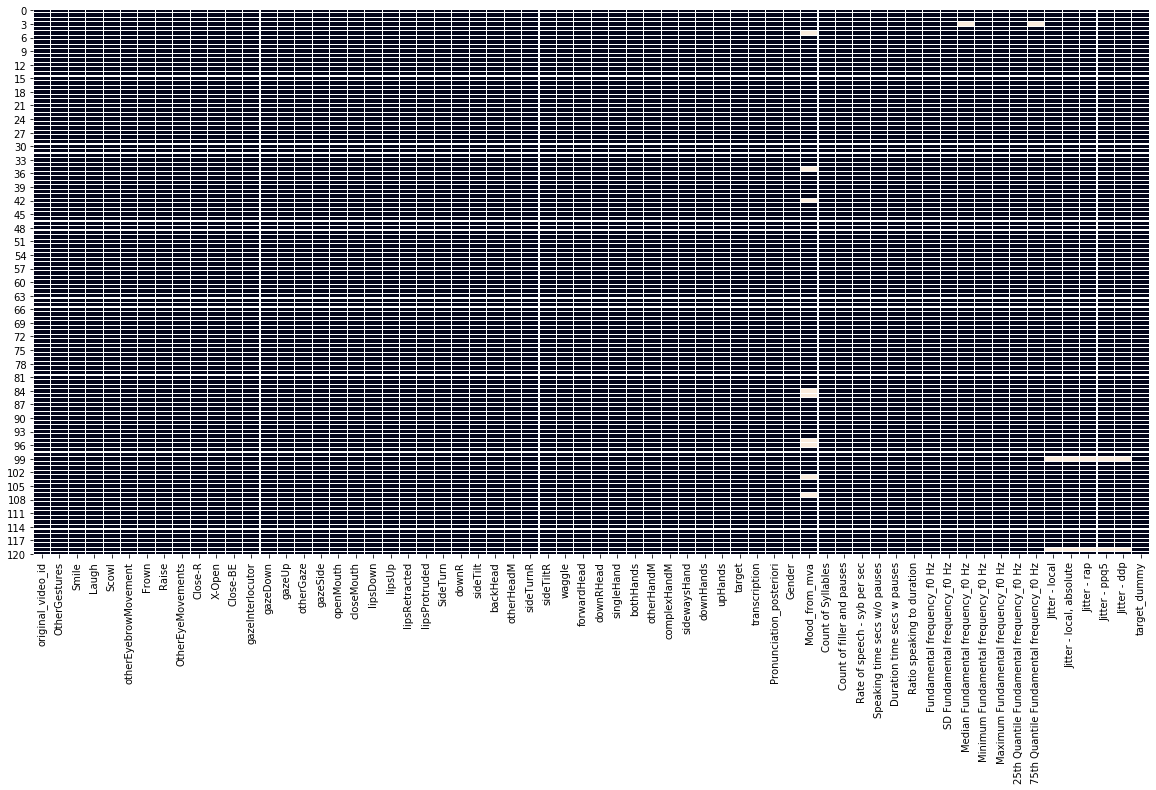

In [9]:
#Lets now have a look at missing values using a heatmap to help visualise the missing data
plt.figure(figsize=(20,10))
sns.heatmap(df_original.isnull(), cbar=False, linewidths=0.1)
#The heatmap suggests that most missing values
#are  associated with the my-voice-analysis, which shows that there are 
#particular audio files it was not able to extract features from. There are also 
#a couple of rows where Jitter information was not extracted.  

In [10]:
#Inspecting unique values in Gender reveals we have 'Voice not recognized' as a value
print("Unique values in 'Gender' are:", df_original['Gender'].unique())
#Investigating the size of each unique value in the column shows that at least 9 
#cases are missing information. This may mean that other information was not able to 
#be extracted. This may be due to background noises or other issues in the original audio
print("\nUnique Value Counts for:",df_original.groupby('Gender').size())
print("\nTotal filled values in gender column:",df_original.groupby('Gender').size().sum())
#Inspecting the count in another column that was based on extracted features from my-voice-analysis
#reveals a similar loss of 9 cases. This could be a problems when it comes to modelling
print("\nTotal filled values in Mood_from_mva column:",df_original.groupby('Mood_from_mva').size().sum())

Unique values in 'Gender' are: ['a female' 'a Male' 'Voice not recognized']

Unique Value Counts for: Gender
Voice not recognized     9
a Male                  44
a female                68
dtype: int64

Total filled values in gender column: 121

Total filled values in Mood_from_mva column: 112


In [11]:
#I decided to recode the Gender to a new variable called Gender_dummy that drops all non-identified genders
#Where 0 = Female and 1 = Male.
df_original['Gender_dummy'] = df_original['Gender'].apply(lambda x: 1 if x == 'a Male' else 0 if x == 'a female' else np.nan)
print(df_original.groupby('Gender_dummy').size())
print('\nMissing values on Gender_dummy:', df_original['Gender_dummy'].isnull().sum())
#This leaves us with 68 females and 44 male speakers in the data-set
#However, there is 9 missing data points for these two variables. Gender, will be important
#for frequency of voice


Gender_dummy
0.0    68
1.0    44
dtype: int64

Missing values on Gender_dummy: 9


In [12]:
#The Mood_from_mva is information extracted from the audio wav files using the my-voice-analysis library
print("Unique Value Counts for:",df_original.groupby('Mood_from_mva').size())
print("\nMissing values on Mood_from_mva:",df_original.Mood_from_mva.isnull().sum())
#Again there are 9 missing values. 

#Given these missing values and that is not very clear as to how these are working and being 
# calculated based on the documentation provided, it may be appropriate to drop these from the analysis
#Furthermore, investigating the sentiment alignment may be more appropriate given 
#that those being deceptive tend to use more negative emotion words (Newman, Pennebaker, Berry, & Richards, 2003)

Unique Value Counts for: Mood_from_mva
Reading                  21
Showing no emotion       77
speaking passionately    14
dtype: int64

Missing values on Mood_from_mva: 9


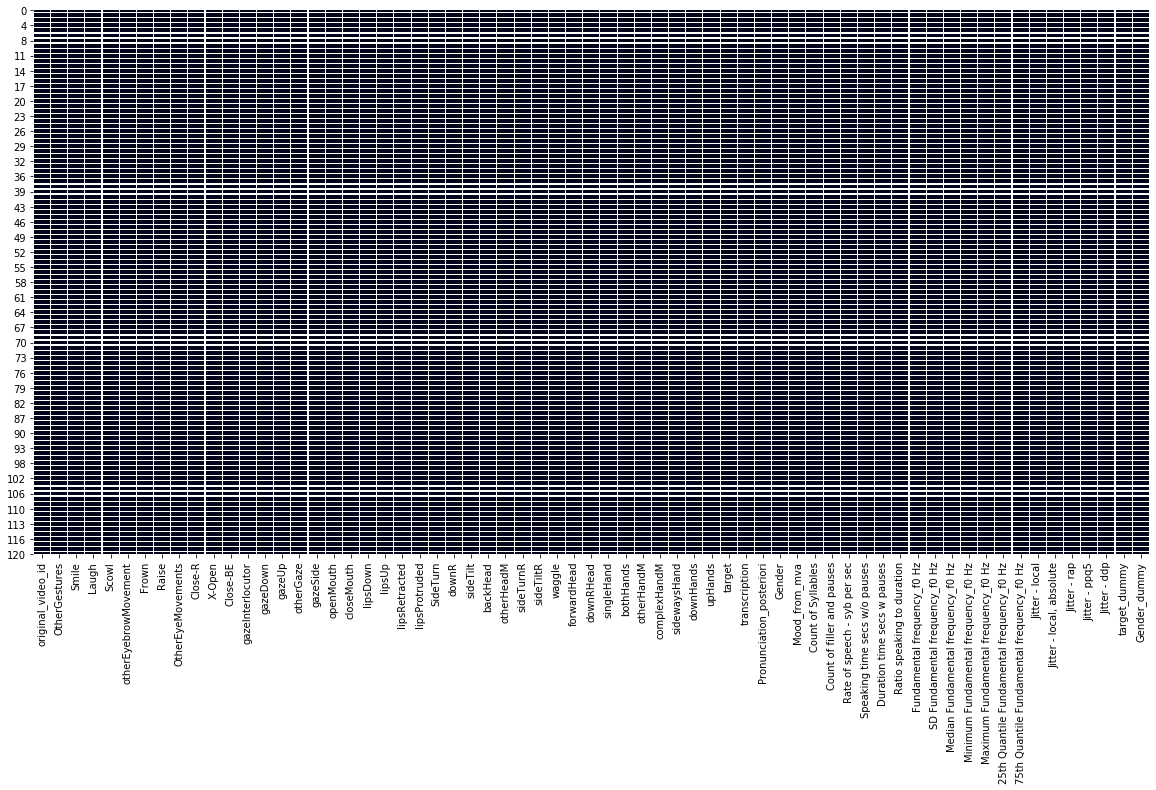

In [13]:
#As we won't lose too many rows (total 12), I will simply drop all the rows with missing values
df_original.dropna(inplace=True)
#Relooking at the heatmap of missing values, can see now we have no missing values for processing
plt.figure(figsize=(20,10))
sns.heatmap(df_original.isnull(), cbar=False, linewidths=0.1)

In [14]:
#Lets also review the descriptive stats for each variable. 
df_original.describe().T

,count,mean,std,min,25%,50%,75%,max
OtherGestures,109.0,0.660550,0.475710,0.000000,0.000000,1.000000,1.000000,1.000000
Smile,109.0,0.137615,0.346086,0.000000,0.000000,0.000000,0.000000,1.000000
Laugh,109.0,0.009174,0.095783,0.000000,0.000000,0.000000,0.000000,1.000000
Scowl,109.0,0.192661,0.396210,0.000000,0.000000,0.000000,0.000000,1.000000
otherEyebrowMovement,109.0,0.293578,0.457504,0.000000,0.000000,0.000000,1.000000,1.000000
Frown,109.0,0.201835,0.403224,0.000000,0.000000,0.000000,0.000000,1.000000
Raise,109.0,0.504587,0.502288,0.000000,0.000000,1.000000,1.000000,1.000000
OtherEyeMovements,109.0,0.467890,0.501273,0.000000,0.000000,0.000000,1.000000,1.000000
Close-R,109.0,0.394495,0.491000,0.000000,0.000000,0.000000,1.000000,1.000000
X-Open,109.0,0.100917,0.302611,0.000000,0.000000,0.000000,0.000000,1.000000


In [15]:
#otherGaze and backHead both have no observations 
#(mean of 0 and std of 0) therefore can be dropped as contains no useful information
df_original.drop(columns=['otherGaze','backHead'], inplace=True)

In [16]:
#Lets now have a look at the final data set info to see what we have left in the dataset.. 
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 120
Data columns (total 63 columns):
original_video_id                            109 non-null object
OtherGestures                                109 non-null int64
Smile                                        109 non-null int64
Laugh                                        109 non-null int64
Scowl                                        109 non-null int64
otherEyebrowMovement                         109 non-null int64
Frown                                        109 non-null int64
Raise                                        109 non-null int64
OtherEyeMovements                            109 non-null int64
Close-R                                      109 non-null int64
X-Open                                       109 non-null int64
Close-BE                                     109 non-null int64
gazeInterlocutor                             109 non-null int64
gazeDown                                     109 non-null int6

target
deceptive    57
truthful     52
dtype: int64


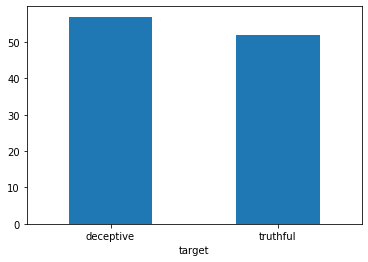

In [17]:
#Inspecting the target variables after dropping of rows with missing values shows
#we have 57 deceptive and 52 truthful cases, which is smaller than prefered but is relatively balanced and 
#we have data for all rows
print(df_original.groupby(by='target').size())
df_original.groupby(by='target').size().plot(kind='bar',rot=0)

In [18]:
#Lets finally look at the shape of our data
df_original.shape
#As can be seen, we have 109 rows and 64 columns after the dropping of our null values. 

(109, 63)

### EDA

In [19]:
#Investigating descriptive statistics of appropriate variables
df_original.describe().T

,count,mean,std,min,25%,50%,75%,max
OtherGestures,109.0,0.660550,0.475710,0.000000,0.000000,1.000000,1.000000,1.000000
Smile,109.0,0.137615,0.346086,0.000000,0.000000,0.000000,0.000000,1.000000
Laugh,109.0,0.009174,0.095783,0.000000,0.000000,0.000000,0.000000,1.000000
Scowl,109.0,0.192661,0.396210,0.000000,0.000000,0.000000,0.000000,1.000000
otherEyebrowMovement,109.0,0.293578,0.457504,0.000000,0.000000,0.000000,1.000000,1.000000
Frown,109.0,0.201835,0.403224,0.000000,0.000000,0.000000,0.000000,1.000000
Raise,109.0,0.504587,0.502288,0.000000,0.000000,1.000000,1.000000,1.000000
OtherEyeMovements,109.0,0.467890,0.501273,0.000000,0.000000,0.000000,1.000000,1.000000
Close-R,109.0,0.394495,0.491000,0.000000,0.000000,0.000000,1.000000,1.000000
X-Open,109.0,0.100917,0.302611,0.000000,0.000000,0.000000,0.000000,1.000000


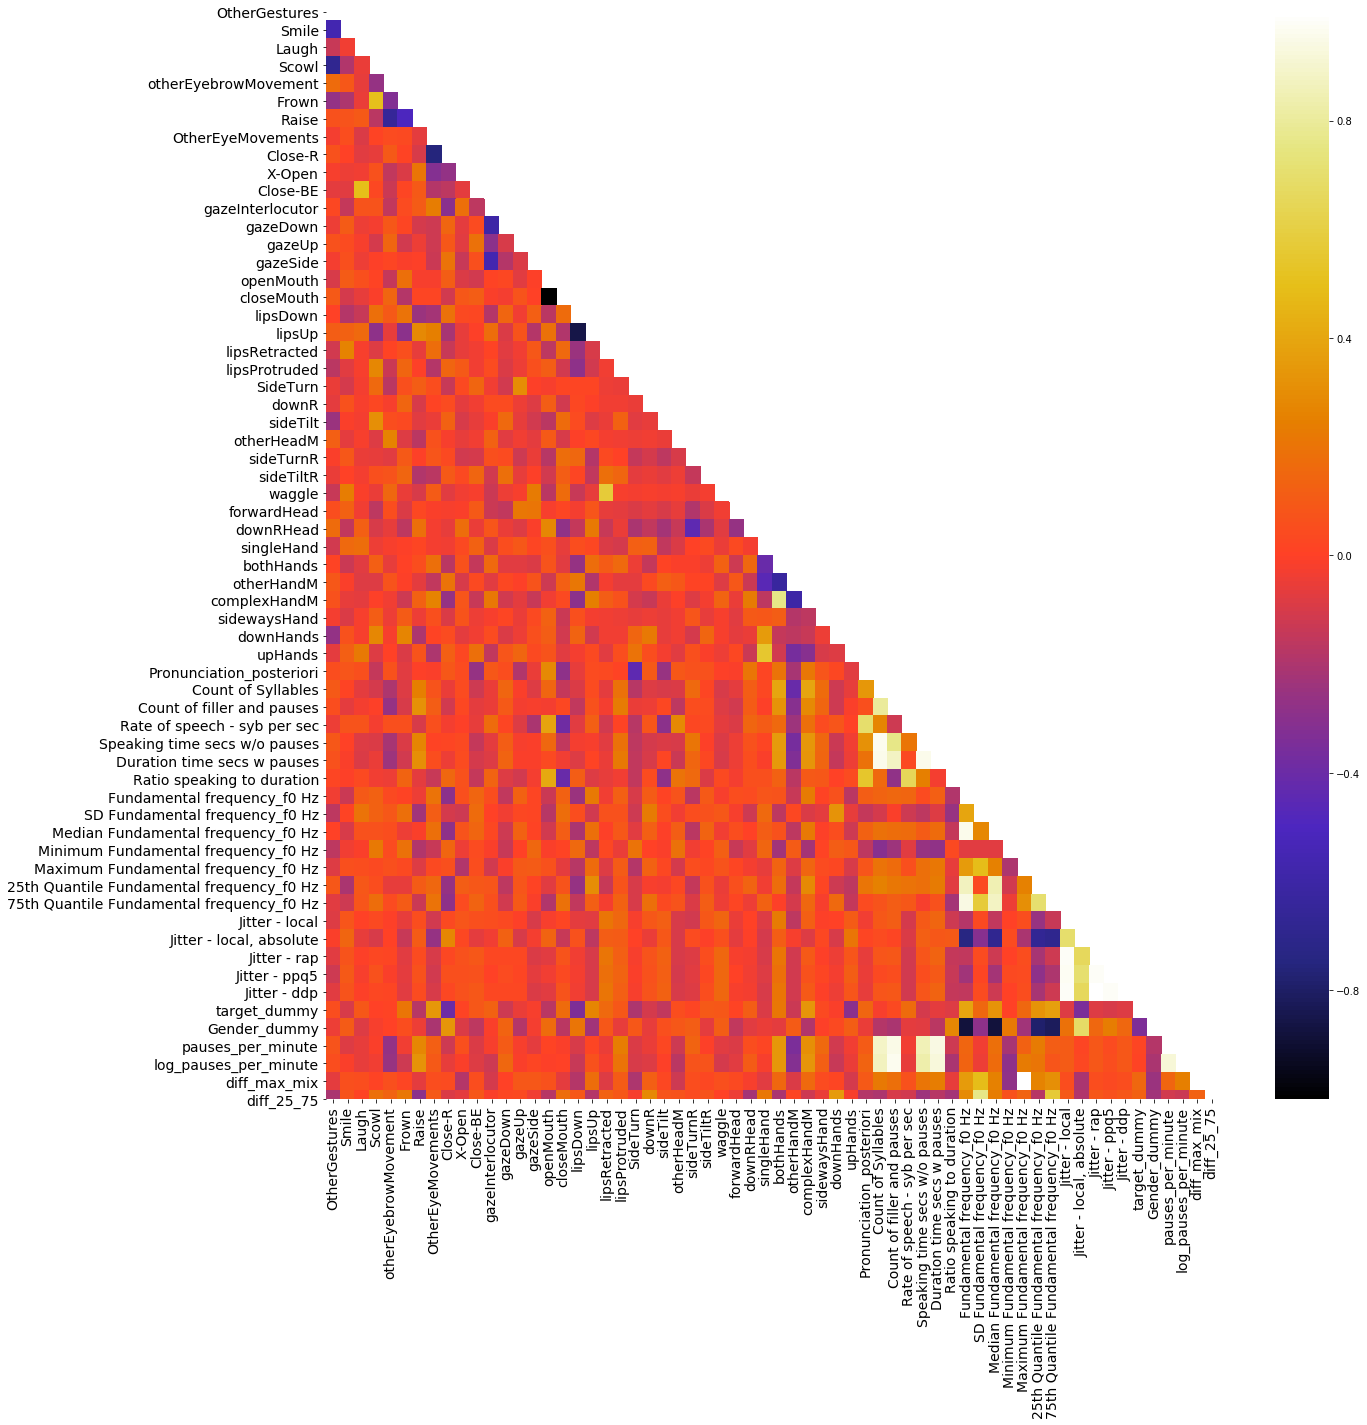

In [87]:
# plot heatmap to check correlation
data_corr = df_original.corr()
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20, 20))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(data_corr, mask=mask, ax=ax, cmap='CMRmap')
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()


Text(0.5, 1.0, 'Gender Breakdown')

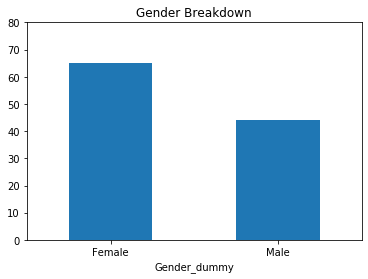

In [20]:
#Investigate Male and Female breakdown in dataset
df_original.groupby(by='Gender_dummy').size().plot(kind='bar',rot=0)
gender_labels= ['Female','Male']
positions = (0,1)
plt.xticks(positions,gender_labels)
plt.ylim([0, 80])
plt.title("Gender Breakdown")

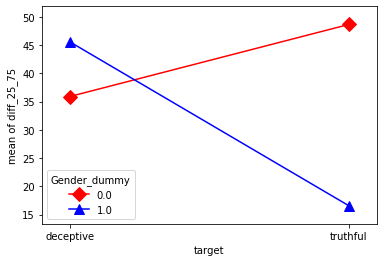

In [158]:
#To investigate whether gender may interact with fundamental frequency, the simple slopes plot
#looks at potential interactions witht the target. Here, there does not seem to be much of an interation.
gender_target_groupby = df_original.groupby(by=['Gender_dummy','target'])
# yyy = pd.DataFrame(gender_target_groupby['Fundamental frequency_f0 Hz'].describe()['mean']).reset_index()
# plt.bar(gender_target_groupby,df_original['Fundamental frequency_f0 Hz'])
# interaction_plot()
statsmodels.graphics.factorplots.interaction_plot(df_original['target'],
                                                  df_original['Gender_dummy'],
                                                  df_original['diff_25_75'],
                                                  colors=['red','blue'], 
                                                  markers=['D','^'], 
                                                  ms=10)
plt.show()

Gender_dummy
0.0    [[AxesSubplot(0.125,0.805248;0.0767327x0.07475...
1.0    [[AxesSubplot(0.125,0.805248;0.0767327x0.07475...
dtype: object

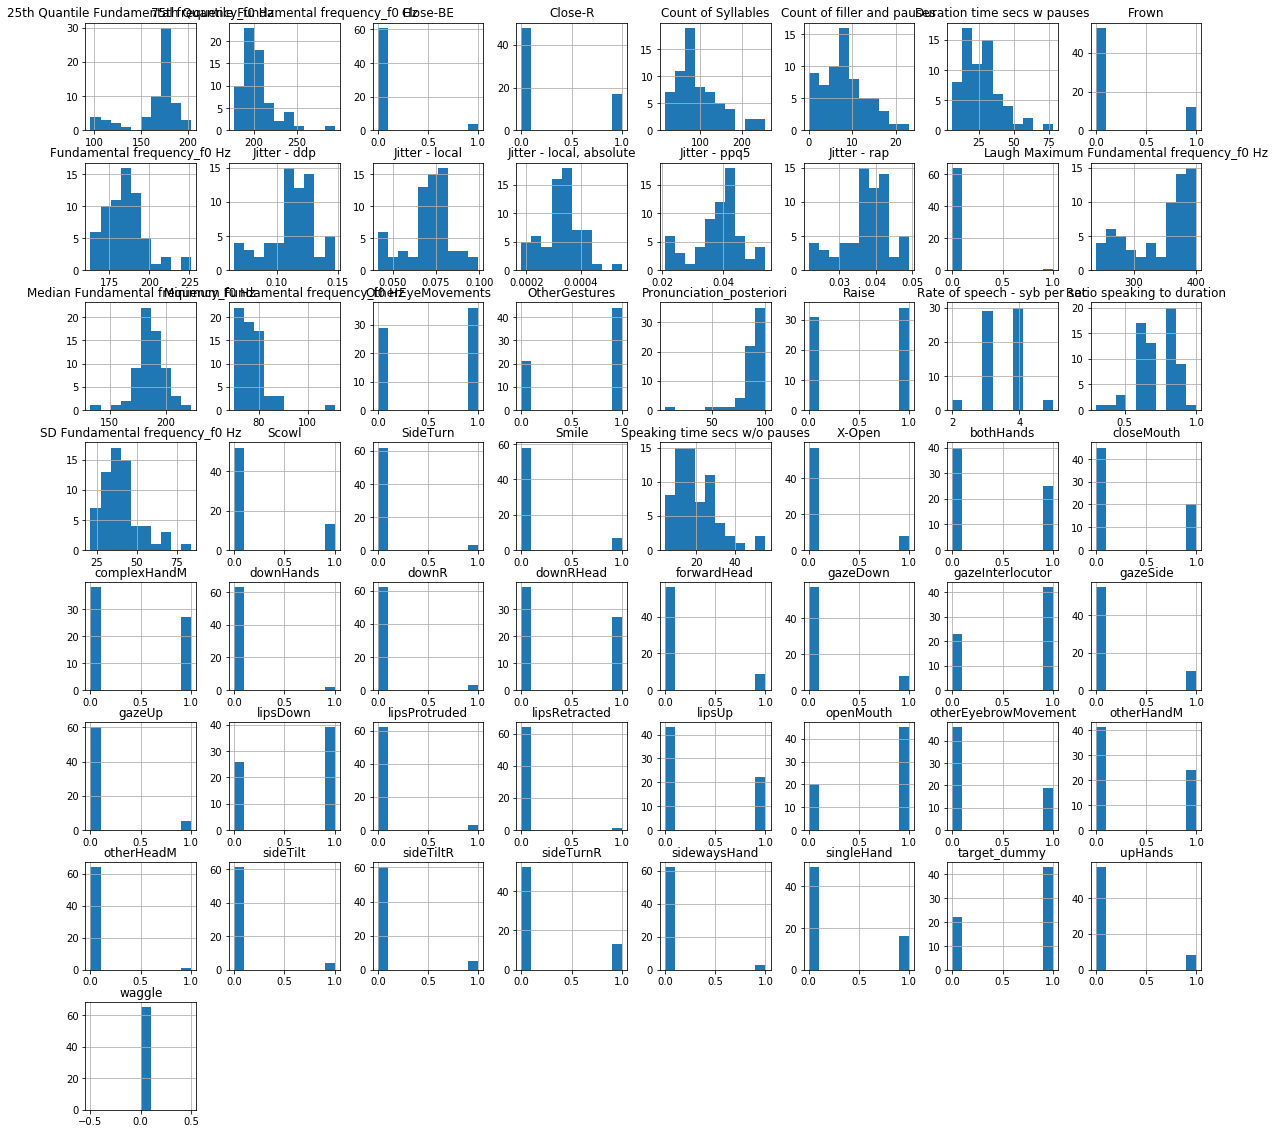

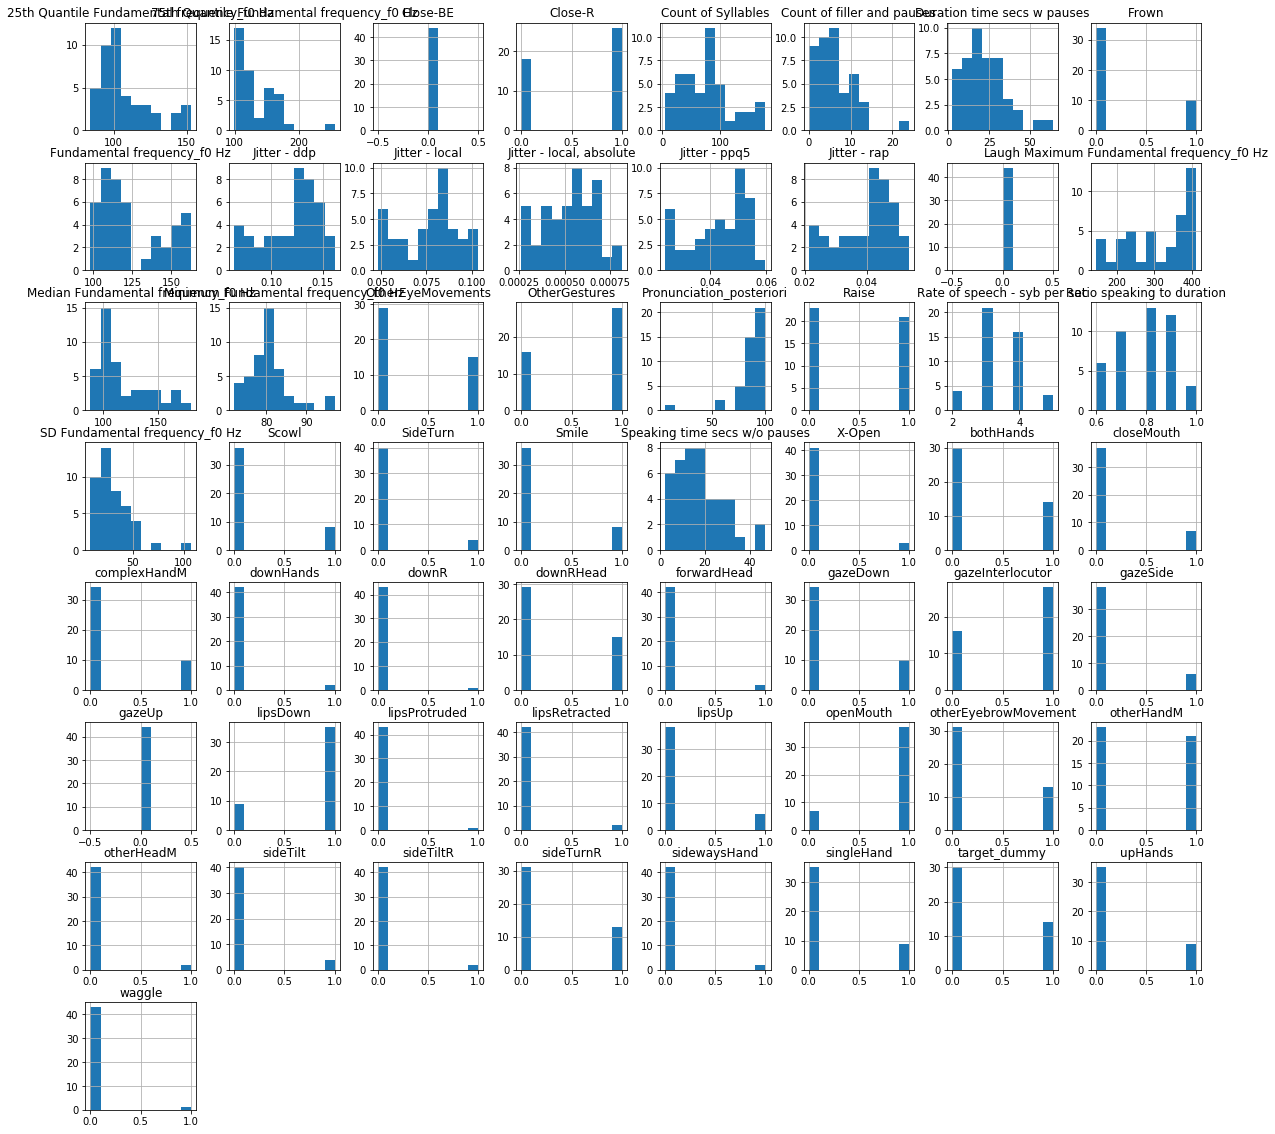

In [22]:
gender_groupby = df_original.groupby(by='Gender_dummy')
gender_groupby.hist(figsize=(20,20))

##### EDA: Gesture Data 
The first part of the EDA looks at data available for gestures.

In [23]:
#First, I have created variables for identification of how specific features relate to overarching gesture categories
#as specified in the MUMIN coding scheme. 
general_face =          ['Smile',
                         'Laugh',
                         'Scowl',
                         'OtherGestures']
eyebrows =              ['Frown',
                         'Raise',
                         'otherEyebrowMovement']
eyes =                  ['X-Open',
                         'Close-BE',
                         'Close-R',
                         'OtherEyeMovements']
gaze =                  ['gazeInterlocutor',
                         'gazeDown',
                         'gazeUp',
                         'gazeSide']
mouth =                 ['openMouth',
                         'closeMouth']
lips =                  ['lipsDown',
                         'lipsUp',
                         'lipsRetracted',
                         'lipsProtruded',
                         'target']
head_movements =        ['SideTurn',
                         'downR',
                         'sideTilt',
                         'otherHeadM',
                         'sideTurnR',
                         'sideTiltR',
                         'waggle',
                         'forwardHead',
                         'downRHead']
hand_gestures =         ['singleHand',
                         'bothHands',
                         'otherHandM',
                         'complexHandM',
                         'sidewaysHand',
                         'downHands',
                         'upHands']

In [24]:
#These pull out percentage information for each of the features specified above.
#np.mean can be used here as the variables are essentially dummy coded.
general_face_behs = df_original.groupby(by='target')[general_face].agg(np.mean).T
eyebrows_behs = df_original.groupby(by='target')[eyebrows].agg(np.mean).T
eyes_behs = df_original.groupby(by='target')[eyes].agg(np.mean).T
gaze_behs = df_original.groupby(by='target')[gaze].agg(np.mean).T
mouth_behs = df_original.groupby(by='target')[mouth].agg(np.mean).T
lips_behs = df_original.groupby(by='target')[lips].agg(np.mean).T
head_movement_behs = df_original.groupby(by='target')[head_movements].agg(np.mean).T
hand_gestures_behs = df_original.groupby(by='target')[hand_gestures].agg(np.mean).T

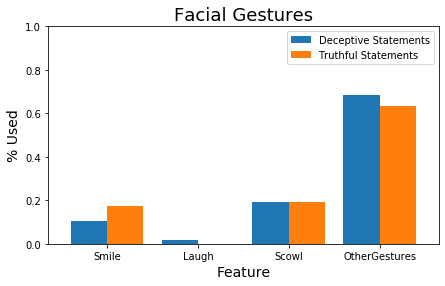

In [25]:
#Plots Facial Gestures % used by Deceptive Truthful Class
general_face_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Facial Gestures', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

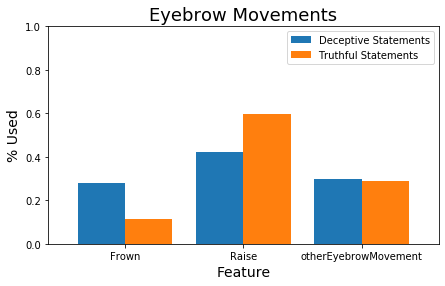

In [26]:
#Plots eyebrows_behs % used by Deceptive Truthful Class
eyebrows_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Eyebrow Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

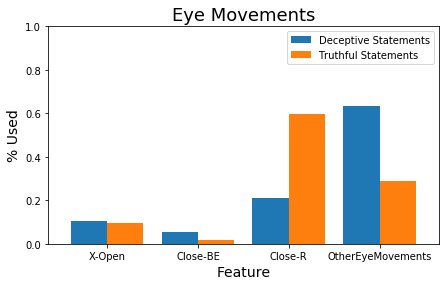

In [27]:
#Plots eyes_behs % used by Deceptive Truthful Class
eyes_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Eye Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

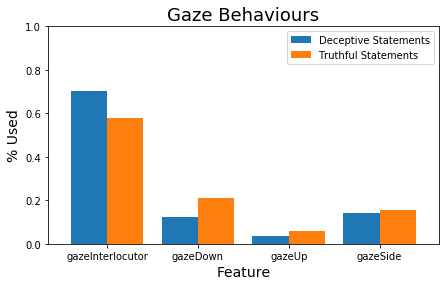

In [28]:
#Plots gaze_behs % used by Deceptive Truthful Class
gaze_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Gaze Behaviours', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

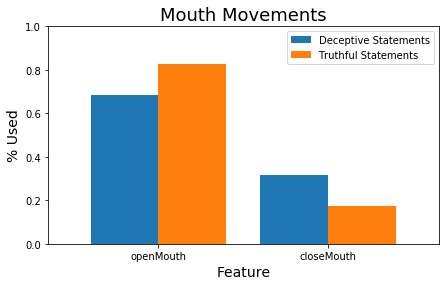

In [29]:
#Plots mouth_behs % used by Deceptive Truthful Class
mouth_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Mouth Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

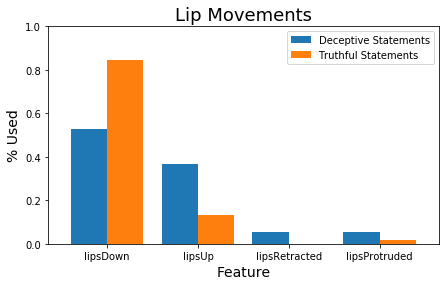

In [30]:
#Plots lips_behs % used by Deceptive Truthful Class
lips_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Lip Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

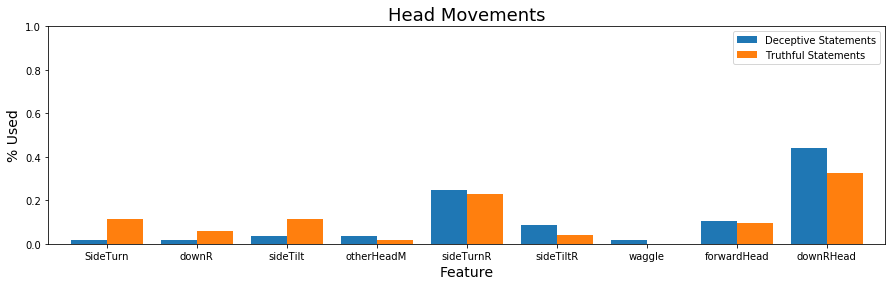

In [31]:
#Plots head_movement_behs % used by Deceptive Truthful Class
head_movement_behs.plot(kind='bar', rot=0, figsize=(15,4), legend=False, width=0.8)
plt.title('Head Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

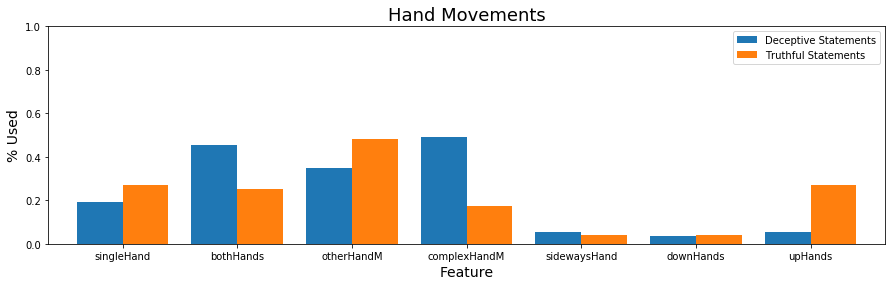

In [32]:
#Plots hand_gestures_behs % used by Deceptive Truthful Class
hand_gestures_behs.plot(kind='bar', rot=0, figsize=(15,4), legend=False, width=0.8)
plt.title('Hand Movements', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.0)
plt.show()

In [33]:
gender_groupby.describe()[general_face].T

Gender_dummy               0.0        1.0
Smile         count  65.000000  44.000000
              mean    0.107692   0.181818
              std     0.312404   0.390154
              min     0.000000   0.000000
              25%     0.000000   0.000000
              50%     0.000000   0.000000
              75%     0.000000   0.000000
              max     1.000000   1.000000
Laugh         count  65.000000  44.000000
              mean    0.015385   0.000000
              std     0.124035   0.000000
              min     0.000000   0.000000
              25%     0.000000   0.000000
              50%     0.000000   0.000000
              75%     0.000000   0.000000
              max     1.000000   0.000000
Scowl         count  65.000000  44.000000
              mean    0.200000   0.181818
              std     0.403113   0.390154
              min     0.000000   0.000000
              25%     0.000000   0.000000
              50%     0.000000   0.000000
              75%     0.000000   0.000000
              max     1.000000   1.000000
OtherGestures count  65.000000  44.000000
              mean    0.676923   0.636364
              std     0.471291   0.486607
              min     0.000000   0.000000
              25%     0.000000   0.000000
              50%     1.000000   1.000000
              75%     1.000000   1.000000
              max     1.000000   1.000000

#####  EDA: Vocal Data 
The second part of the EDA looks at data available for voice features.

In [34]:
vocal_features_counts = ['Count of Syllables',
                         'Count of filler and pauses']
vocal_features_rate =   ['Rate of speech - syb per sec']
vocal_features_time =   ['Speaking time secs w/o pauses',
                         'Duration time secs w pauses']      
vocal_features_ratio =  ['Ratio speaking to duration']
vocal_features_jitter = ['Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp']

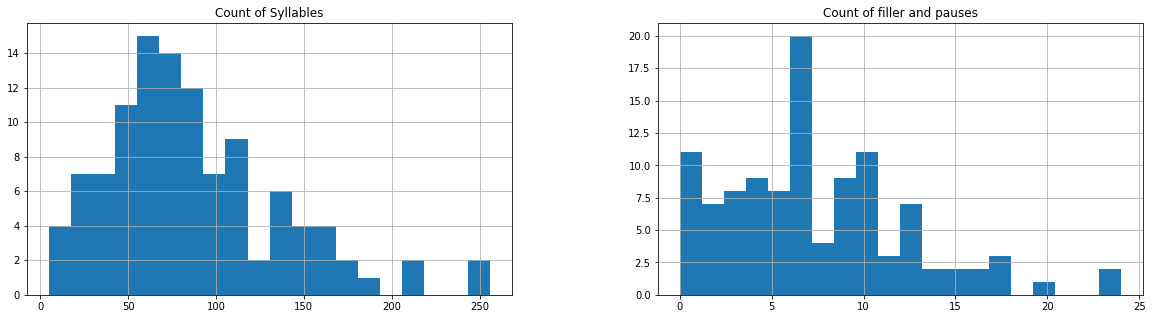

In [35]:
df_original.hist(column=vocal_features_counts,figsize=(20,5), bins=20)
plt.show()

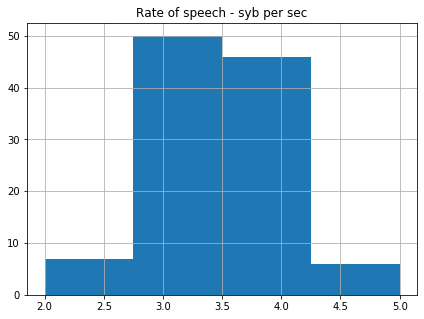

In [36]:
df_original.hist(column=vocal_features_rate,figsize=(7,5), bins=4)
plt.show()

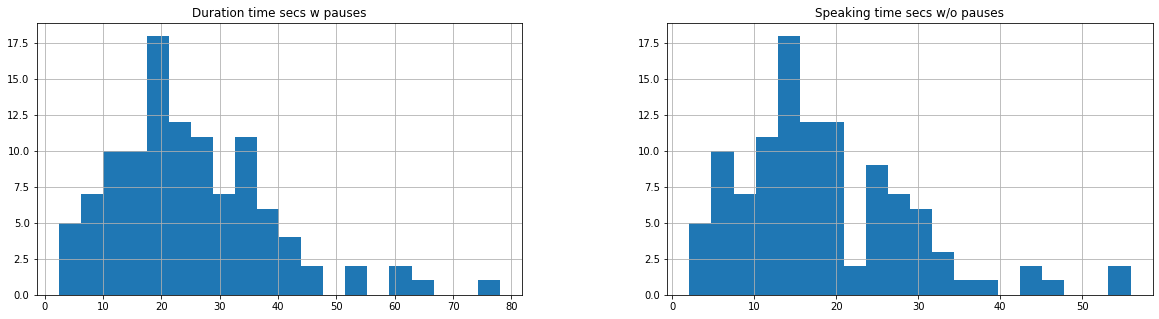

In [37]:
df_original.hist(column=vocal_features_time,figsize=(20,5), bins=20)
plt.show()

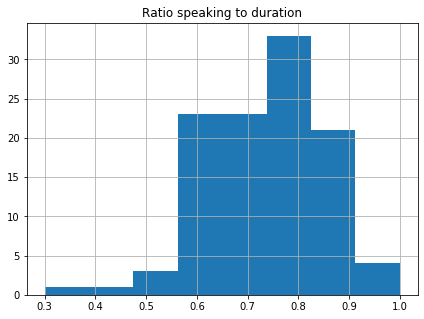

In [38]:
df_original.hist(column=vocal_features_ratio,figsize=(7,5), bins=8)
plt.show()

In [159]:
df_original['gender_interaction_diff_25_75'] = df_original.Gender_dummy * df_original.diff_25_75

In [162]:
from scipy.stats.stats import pearsonr

vocal_features_list = [#'Count of Syllables',
                         #'Count of filler and pauses',
                         'target_dummy',
                         'gender_interaction_diff_25_75',
#                          'Gender_dummy',
                         'Rate of speech - syb per sec',
#                          'Speaking time secs w/o pauses',
#                          'Duration time secs w pauses',
                         'log_pauses_per_minute',
                         'Ratio speaking to duration',
                         'Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75',
                         'Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp',
    
                         ]



# sns.heatmap(
    
# gender_group = df_original.groupby(by='Gender_dummy')

df_original[vocal_features_list].corr(method='spearman') #.sort_values(by='target_dummy')



,target_dummy,gender_interaction_diff_25_75,Rate of speech - syb per sec,log_pauses_per_minute,Ratio speaking to duration,Fundamental frequency_f0 Hz,SD Fundamental frequency_f0 Hz,Median Fundamental frequency_f0 Hz,Minimum Fundamental frequency_f0 Hz,Maximum Fundamental frequency_f0 Hz,25th Quantile Fundamental frequency_f0 Hz,75th Quantile Fundamental frequency_f0 Hz,diff_max_mix,diff_25_75,Jitter - local,"Jitter - local, absolute",Jitter - rap,Jitter - ppq5,Jitter - ddp
target_dummy,1.000000,-0.231856,0.161995,0.010508,-0.086115,0.394046,0.133100,0.276422,0.026080,0.092535,0.334960,0.313831,0.105387,0.317914,-0.173380,-0.329831,-0.173380,-0.160537,-0.173380
gender_interaction_diff_25_75,-0.231856,1.000000,-0.053275,-0.222492,0.268544,-0.756389,-0.265533,-0.747944,0.306895,-0.053427,-0.686672,-0.696395,-0.095680,-0.229564,0.228090,0.550632,0.193968,0.249866,0.193968
Rate of speech - syb per sec,0.161995,-0.053275,1.000000,-0.068799,0.653655,0.154024,-0.143376,0.149003,-0.072807,0.001184,0.193345,0.076241,0.005997,-0.051056,-0.139348,-0.143081,-0.159437,-0.147149,-0.159437
log_pauses_per_minute,0.010508,-0.222492,-0.068799,1.000000,-0.229142,0.136797,0.010388,0.178507,-0.400966,0.191672,0.225936,0.136436,0.230388,-0.037292,0.108398,0.023682,0.091281,0.058513,0.091281
Ratio speaking to duration,-0.086115,0.268544,0.653655,-0.229142,1.000000,-0.181431,-0.257417,-0.180616,0.070203,-0.046808,-0.100950,-0.224338,-0.062890,-0.157962,-0.088441,0.005378,-0.105660,-0.094343,-0.105660
Fundamental frequency_f0 Hz,0.394046,-0.756389,0.154024,0.136797,-0.181431,1.000000,0.394273,0.901863,-0.138275,0.208550,0.872272,0.900395,0.228720,0.548417,-0.265545,-0.708952,-0.247753,-0.273469,-0.247753
SD Fundamental frequency_f0 Hz,0.133100,-0.265533,-0.143376,0.010388,-0.257417,0.394273,1.000000,0.397682,-0.120040,0.452910,0.153579,0.566565,0.464406,0.656665,0.024168,-0.281642,0.033519,0.003494,0.033519
Median Fundamental frequency_f0 Hz,0.276422,-0.747944,0.149003,0.178507,-0.180616,0.901863,0.397682,1.000000,-0.084269,0.076840,0.826808,0.883508,0.088795,0.549235,-0.190000,-0.604299,-0.175108,-0.223126,-0.175108
Minimum Fundamental frequency_f0 Hz,0.026080,0.306895,-0.072807,-0.400966,0.070203,-0.138275,-0.120040,-0.084269,1.000000,-0.148063,-0.157025,-0.103500,-0.268452,0.044015,0.000474,0.092051,-0.008503,0.036855,-0.008503
Maximum Fundamental frequency_f0 Hz,0.092535,-0.053427,0.001184,0.191672,-0.046808,0.208550,0.452910,0.076840,-0.148063,1.000000,0.127466,0.188242,0.987816,0.188371,0.029045,-0.096940,0.005570,0.014332,0.005570


In [39]:
vocal_features_counts_behs = df_original.groupby(by='target')[vocal_features_counts].agg(np.mean).T
vocal_features_rate_behs = df_original.groupby(by='target')[vocal_features_rate].agg(np.mean).T
vocal_features_time_behs = df_original.groupby(by='target')[vocal_features_time].agg(np.mean).T
vocal_features_ratio_behs = df_original.groupby(by='target')[vocal_features_ratio].agg(np.mean).T
vocal_features_jitter_behs = df_original.groupby(by='target')[vocal_features_jitter].agg(np.mean).T

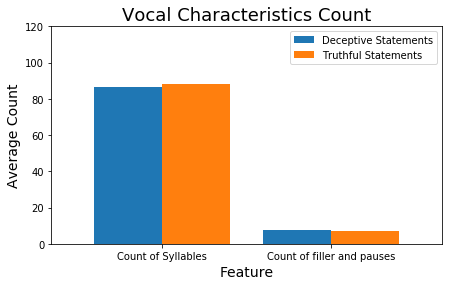

In [40]:
#Plots vocal_features_behs % used by Deceptive Truthful Class
vocal_features_counts_behs.plot(kind='bar', rot=0, figsize=(7,4), legend=False, width=0.8)
plt.title('Vocal Characteristics Count', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('Average Count', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 120)
plt.show()

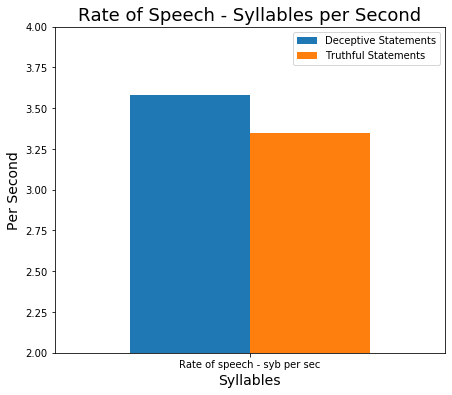

In [41]:
#Plots vocal_features_rate_behs % used by Deceptive Truthful Class
vocal_features_rate_behs.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title('Rate of Speech - Syllables per Second', fontdict={'fontsize': 18})
plt.xlabel('Syllables', fontdict={'fontsize': 14})
plt.ylabel('Per Second', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(2, 4)
plt.show()

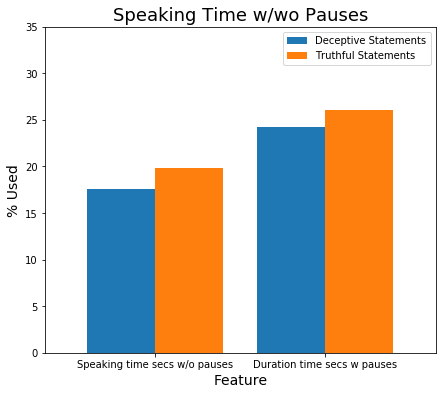

In [42]:
#Plots vocal_features_time_behs % used by Deceptive Truthful Class
vocal_features_time_behs.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title('Speaking Time w/wo Pauses', fontdict={'fontsize': 18})
plt.xlabel('Feature', fontdict={'fontsize': 14})
plt.ylabel('% Used', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 35)
plt.show()

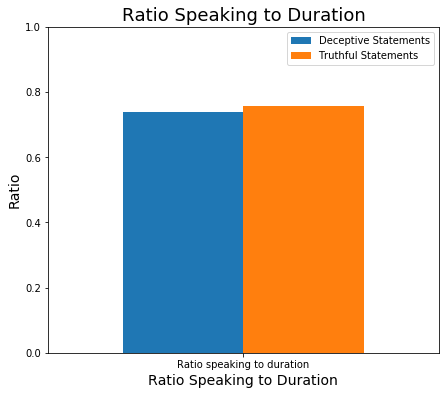

In [43]:
#Plots vocal_features_ratio_behs % used by Deceptive Truthful Class
vocal_features_ratio_behs.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title('Ratio Speaking to Duration', fontdict={'fontsize': 18})
plt.xlabel('Ratio Speaking to Duration', fontdict={'fontsize': 14})
plt.ylabel('Ratio', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1)
plt.show()

##### Jitter

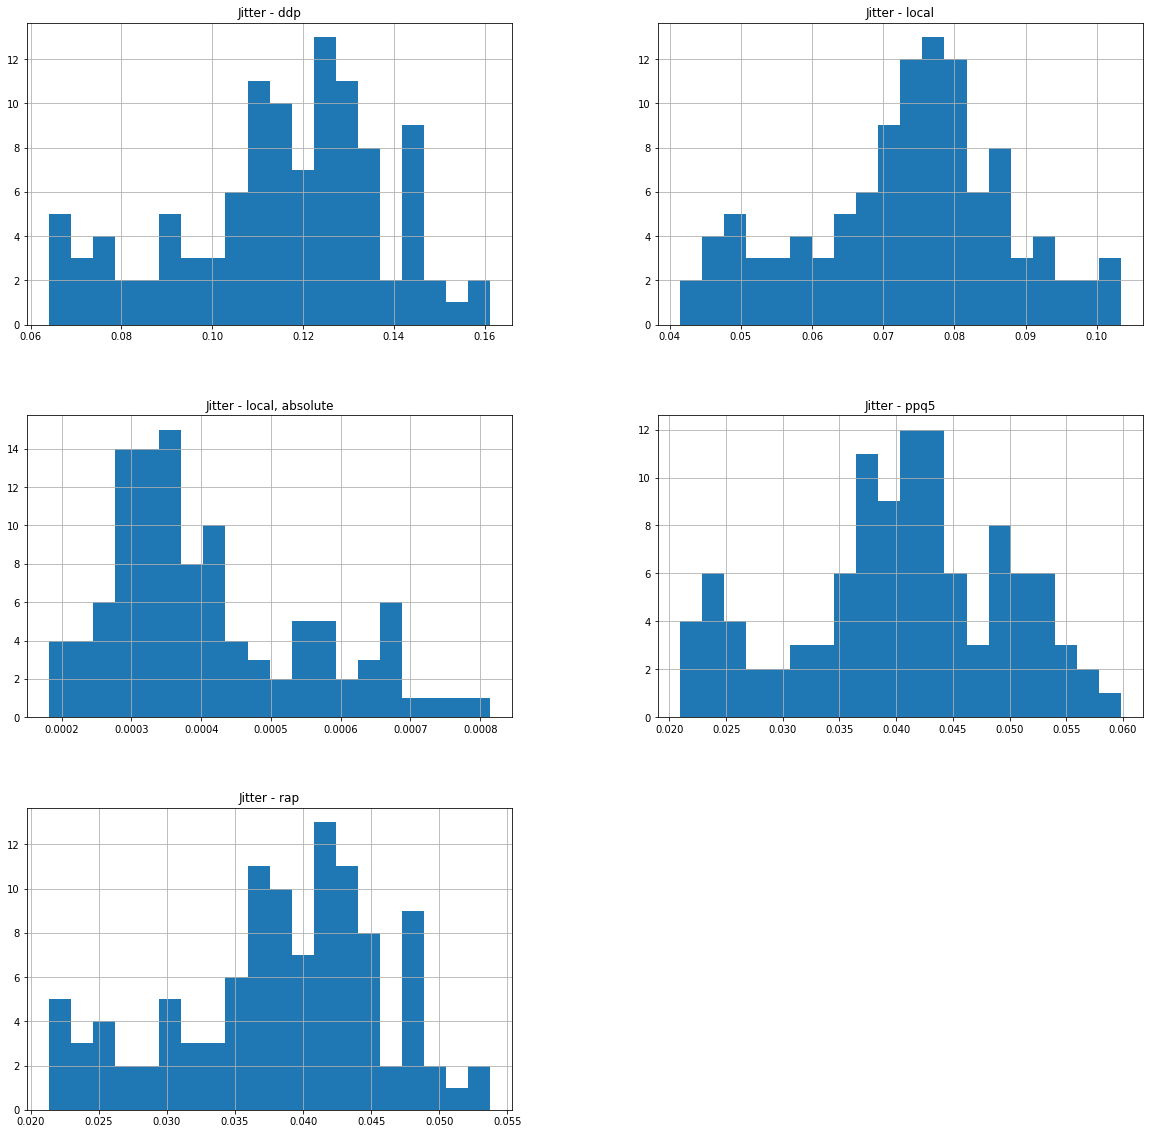

In [44]:
#Lets first have a look at distributions of Jitter
df_original.hist(column=vocal_features_jitter,figsize=(20,20), bins=20)
plt.show()

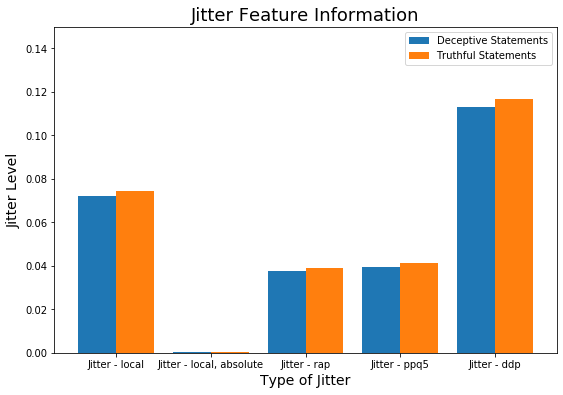

In [45]:
#Plots vocal_features_jitter_behs % used by Deceptive Truthful Class
vocal_features_jitter_behs.plot(kind='bar', rot=0, figsize=(9,6), legend=False, width=0.8)
plt.title('Jitter Feature Information', fontdict={'fontsize': 18})
plt.xlabel('Type of Jitter', fontdict={'fontsize': 14})
plt.ylabel('Jitter Level', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 0.15)
plt.show()

**Pauses per Minute (PPM)**

Given we can expect that individuals need to be careful in what they are saying resulting in slower speech and more pauses, another interesting statistic to explore is the number of pauses per minute speaking. I have calculated this by the following formula:

* **Pauses per minute = ('Duration time secs w pauses' / 60) * 'Count of filler and pauses'**

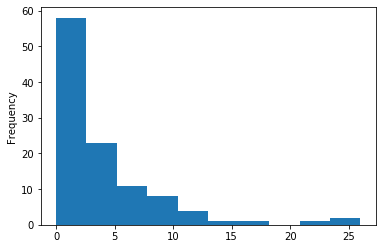

In [46]:
#Investigating the distribution of pauses per minutes reveals a heavily positvely skewed distributed.
#We also have some outliers in the upper range, which may need to be dealt with. 
df_original['pauses_per_minute'] = (df_original['Duration time secs w pauses'] / 60) * df_original['Count of filler and pauses']
df_original['pauses_per_minute'].plot(kind='hist')

In [47]:
#Lets see where the upper and lower bounds for extreme outliers are (+/-3 IQR)
IQR_ppm = df_original['pauses_per_minute'].describe()['75%'] - df_original['pauses_per_minute'].describe()['25%']
upper_range_ppm = df_original['pauses_per_minute'].describe()['75%'] + (IQR_ppm * 3)
lower_range_ppm = df_original['pauses_per_minute'].describe()['25%'] - (IQR_ppm * 3)

print("Upper bound for extreme outliers:",upper_range_ppm)
print("Lower bound for extreme outliers:",lower_range_ppm)

Upper bound for extreme outliers: 18.225000000000005
Lower bound for extreme outliers: -11.81666666666667


In [48]:
#Lets get the highest value that is not an outlier.
max_ppm = df_original[df_original['pauses_per_minute'] < upper_range_ppm]['pauses_per_minute'].max()
#In this case, we have 17.708 as the largest, non-extreme outlier. Therefore, I will windorise the upper extreme values
print("Max non-extreme outlier is:", max_ppm)

Max non-extreme outlier is: 17.708333333333336


In [49]:
df_original.loc[df_original['pauses_per_minute'] > upper_range_ppm]['pauses_per_minute']

64    26.000000
67    23.268333
86    25.640000
Name: pauses_per_minute, dtype: float64

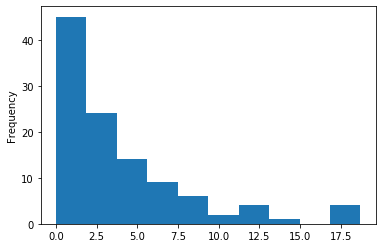

In [50]:
df_original['pauses_per_minute'] = np.where((df_original['pauses_per_minute'] > upper_range_ppm),max_ppm +1,df_original['pauses_per_minute'])
df_original['pauses_per_minute'].plot(kind='hist')

In [51]:
#As the skew still remains, lets log transform the variable to see if this improves the distribution. As some 
#have 0, I have also added 1 to all of the values so that the transformation can occur. 
df_original['log_pauses_per_minute'] = df_original['pauses_per_minute'].agg(lambda x:x + 1).agg(np.log)

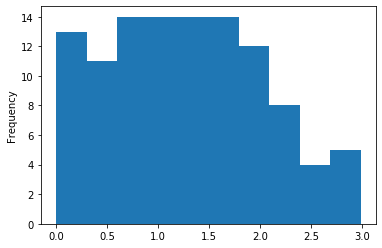

In [52]:
#Inspecting the log transformation has imporved the distribution somewhat but still some issues. 
df_original['log_pauses_per_minute'].plot(kind='hist')

In [53]:
target_groupby = df_original.groupby(by='target')
target_groupby['log_pauses_per_minute'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
deceptive,57.0,1.290354,0.809589,0.000000,0.67039,1.175573,1.909543,2.928969
truthful,52.0,1.273508,0.747930,0.072321,0.73215,1.229153,1.693082,2.981042


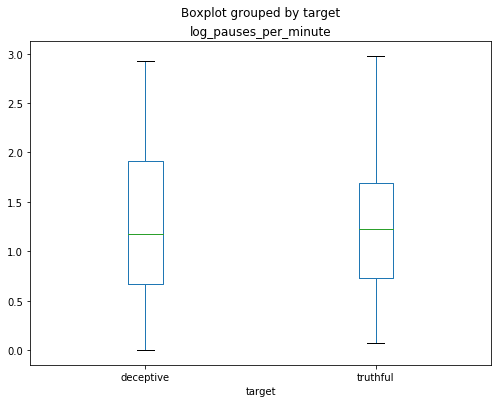

In [54]:
#After windorizing our outliers and log transforming the ppm, there does not seem to 
#be much difference in the pauses per minute within each target class. 
df_original.boxplot(column=['log_pauses_per_minute'],by='target', figsize=(8,6), grid=False)

In [55]:
pauses_per_minute = pd.DataFrame(df_original.groupby(by='target')['log_pauses_per_minute'].agg(np.mean)).T
pauses_per_minute

target,deceptive,truthful
log_pauses_per_minute,1.290354,1.273508


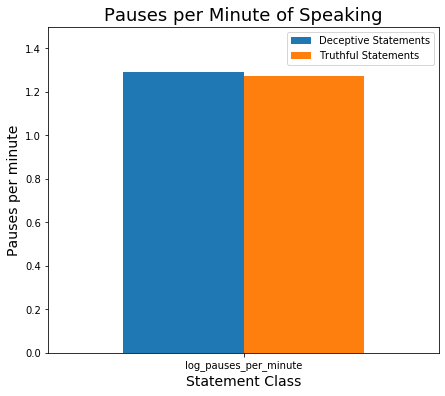

In [56]:
#Plots pauses_per_minute used by Deceptive Truthful Class
pauses_per_minute.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title('Pauses per Minute of Speaking', fontdict={'fontsize': 18})
plt.xlabel('Statement Class', fontdict={'fontsize': 14})

plt.ylabel('Pauses per minute', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 1.5)
plt.show()

While the difference is small, the difference is in the expect diference... those who are engaging in purported truthful statements tend to have *lower* rates of pauses. However, the difference is very small and unlikey to be statistically significant.

Potentially, this may be due to the context of the legal settings or similar in which the individuals are. It may be that those who are lying have prepared their 'stories' in advance to maximise the chance of their narrative remaining consistent while engaged in a high-stakes situation. 

##### Fundamental frequency_f0 Hz

I now turn my attention to the Fundamental frequency_f0 which is the central tendency of the frequency of vibration of the vocal folds during connected speech (Baken & Orlikoff, 2000) and correlates with the perceived pitch of a speaker's voice. The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.

In [57]:
fundamental_frequency_behs = ['Fundamental frequency_f0 Hz',
                              'SD Fundamental frequency_f0 Hz',
                              'Median Fundamental frequency_f0 Hz',
                              'Minimum Fundamental frequency_f0 Hz',
                              'Maximum Fundamental frequency_f0 Hz',
                              '25th Quantile Fundamental frequency_f0 Hz',
                              '75th Quantile Fundamental frequency_f0 Hz']

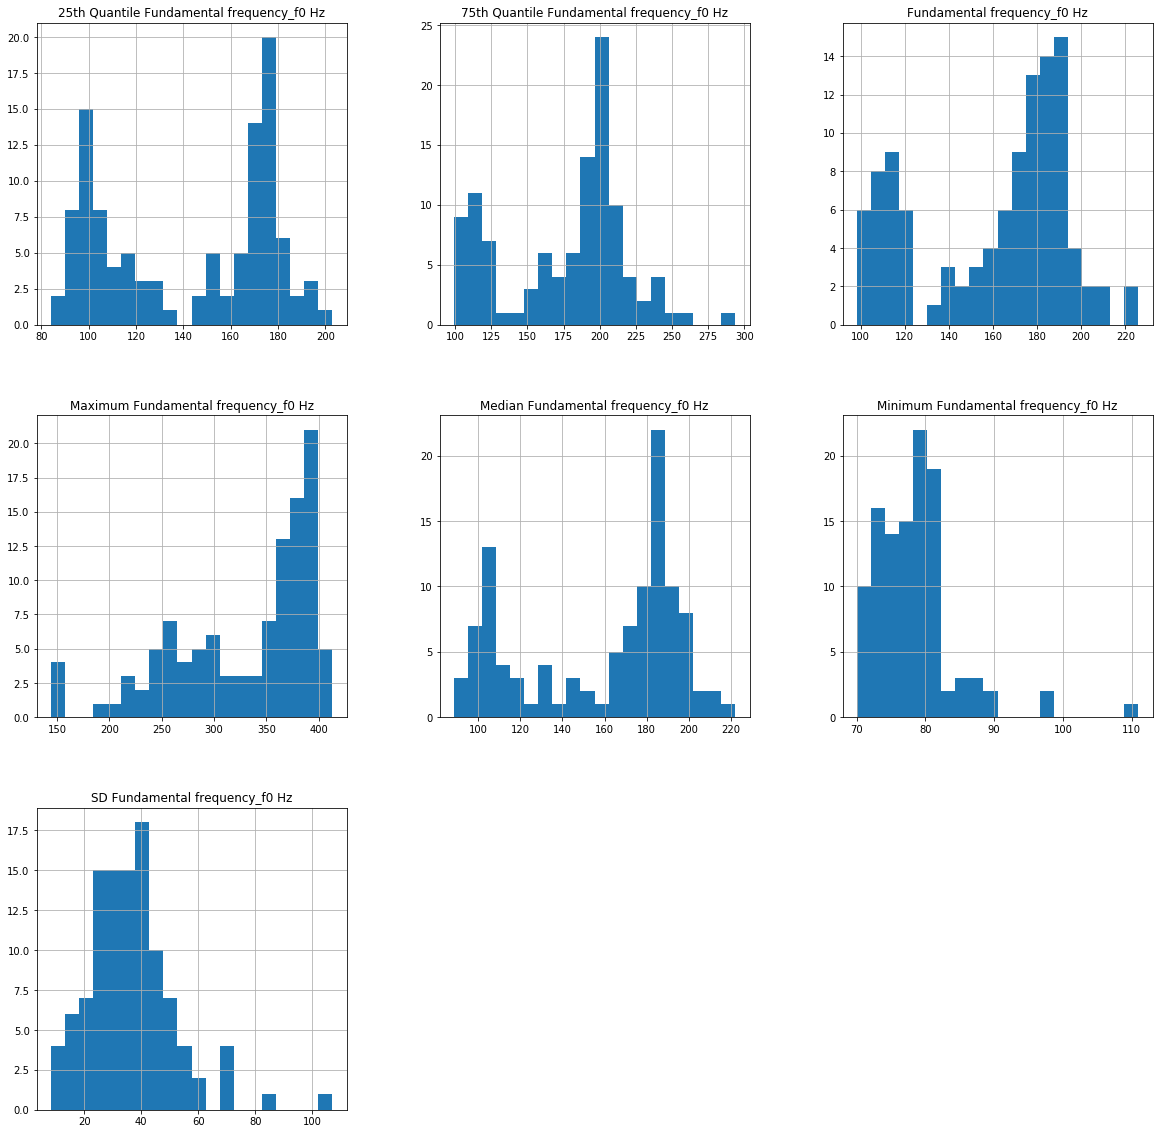

In [58]:
#Lets first have a look at distributions of behaviours related to Fundamental frequency
df_original.hist(column=fundamental_frequency_behs,figsize=(20,20), bins=20)
plt.show()

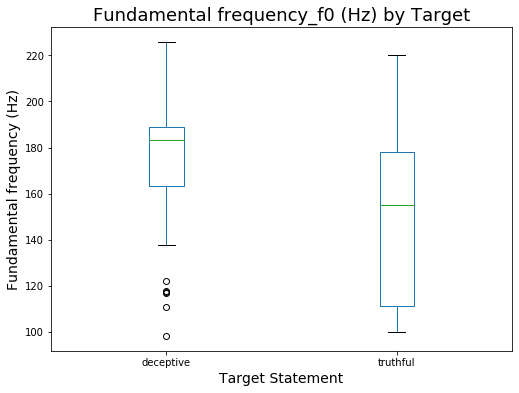

In [59]:
df_original.boxplot(column=['Fundamental frequency_f0 Hz'],by='target', figsize=(8,6), grid=False)
plt.suptitle("")
plt.title('Fundamental frequency_f0 (Hz) by Target', fontdict={'fontsize': 18})
plt.xlabel('Target Statement', fontdict={'fontsize': 14})

plt.ylabel('Fundamental frequency (Hz)', fontdict={'fontsize': 14})
plt.show()

In [60]:
#It may also be interesting to look at the difference in range between the maximum f0 achived and the least.
#These therefore create new variables to explore
#The first calculates the difference between the maxium and minimum frequencies
df_original['diff_max_mix'] = df_original['Maximum Fundamental frequency_f0 Hz'] - df_original['Minimum Fundamental frequency_f0 Hz']
#The first calculates the difference between the 25th and 75th Quantile frequencies
df_original['diff_25_75'] = df_original['75th Quantile Fundamental frequency_f0 Hz'] - df_original['25th Quantile Fundamental frequency_f0 Hz']

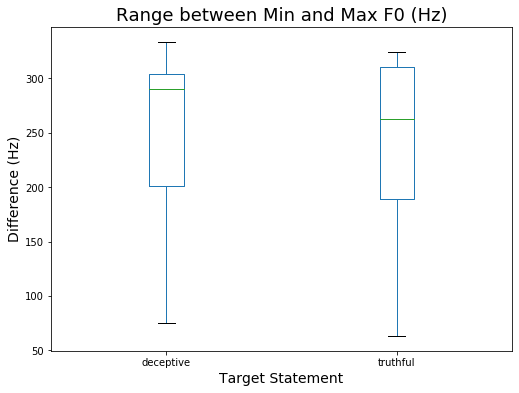

In [61]:
df_original.boxplot(column=['diff_max_mix'],by='target', figsize=(8,6), grid=False)
plt.suptitle("")
plt.title('Range between Min and Max F0 (Hz)', fontdict={'fontsize': 18})
plt.xlabel('Target Statement', fontdict={'fontsize': 14})

plt.ylabel('Difference (Hz)', fontdict={'fontsize': 14})
plt.show()

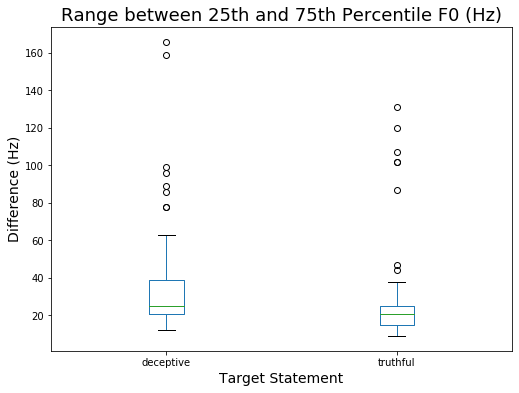

In [62]:
df_original.boxplot(column=['diff_25_75'],by='target', figsize=(8,6), grid=False)
plt.suptitle("")
plt.title('Range between 25th and 75th Percentile F0 (Hz)', fontdict={'fontsize': 18})
plt.xlabel('Target Statement', fontdict={'fontsize': 14})

plt.ylabel('Difference (Hz)', fontdict={'fontsize': 14})
plt.show()

In [63]:
#As we want to model
#specifies the relative path location to save the df_concat data frame just created
data_frame_location = './data/final_data/'
#Gets the date using the datetime module for use in the file name
date_time = datetime.now() 
#Creates the file name string
filename = str('final_data_' + date_time.strftime("%d%b%y_%T")+".csv").replace(':',"")
end_filename = str(data_frame_location + filename)
# end_filename = str(data_frame_location + 'final_data' + date_time.strftime("%d%b%y_%T")+".csv").replace(':',"") 
#And finally writes the df_concat dataframe to a csv file using the end_filename string just created.
df_original.to_csv(end_filename, index=False)

#This confirms the file name and location for use as a reference if required. 
print("File called:",filename,
      '\nplaced in directory:',data_frame_location)
print("Location to copy to book three is: ",end_filename)

File called: final_data_27Feb20_144546.csv 
placed in directory: ./data/final_data/
Location to copy to book three is:  ./data/final_data/final_data_27Feb20_144546.csv


In [64]:
end_filename

'./data/final_data/final_data_27Feb20_144546.csv'

#####  EDA: Word Data 
While I will return to the EDA for NLP during modelling, I will undertake a more basic EDA here for current project PART II purposes. 

It is important to note typical approaches to NLP is to remove commonly used words such as 'I' and 'and' on the assumption that these are not useful. However, pronouns (e.g. 'I')  use has been shown to be correlated to deception. The former is based on the idea of psychological distancing from the lie... where they do not associate themselves subconsiously with it. Therefore, I have decided to not include stop words on the assumption these are important.

In [65]:
#First, I will drop apostrophes in the data set 
df_original.transcription.replace(r"'",'', inplace=True,regex=True)

In [66]:
#Create a stop word list
stop_words_default = list(list(punctuation))
bespoke_stop_words = ['to', '10th','4th','a','alexander','ian','s','t', 'was', 'he','of','is','ammm','so']
stop_words= stop_words_default + bespoke_stop_words

#Initalise a CountVectorizer, which provides a count of the words in each of the transcripts.
vect = CountVectorizer(ngram_range=(1, 2),
                       stop_words=stop_words,
                       token_pattern='\w+',
                       min_df=2)

#This provides a count of the words in each of the transcripts.
# vect = CountVectorizer(ngram_range=(1, 3),
#                        token_pattern='\\b\\w+\\b') #<-- this captures all single case letter including I, which is of interest to the current study

word_count = vect.fit_transform(df_original.transcription)
word_count_df = pd.DataFrame(word_count.toarray(), columns=vect.get_feature_names())
word_count_df = word_count_df.astype('float64')

In [68]:
concat_df = pd.concat([word_count_df.reset_index(drop=True),
                       df_original.reset_index(drop=True)],
                       axis=1)

In [69]:
concat_df[word_count_df.columns] = concat_df[word_count_df.columns].apply(lambda x:(concat_df['Speaking time secs w/o pauses'] /60) * x)

As the length of time across each audio clip differs, it makes sense that we would be more interested in the relative usage over time for each word rather than the absolute count on the assumption that rates of word or combinations of words will differ during each time period either the deception or truthfulness is occuring. Therefore, I now will convert the word count to use per minute count based on the length of time being spoke. 

The formula used is:
* **X_word_use per minute = ('Speaking time secs w/o pauses']/60) * count of word use**

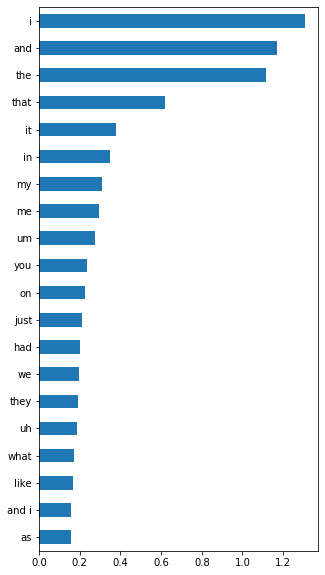

In [70]:
concat_df[word_count_df.columns].agg(np.mean).sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh', figsize=(5,10))

(0, 2)

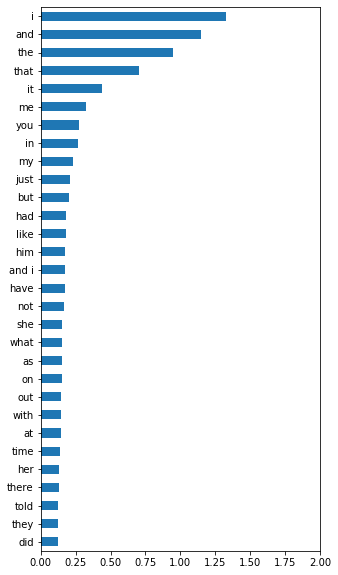

In [78]:
top_twenty_words_deceptive = concat_df.groupby(by='target')[word_count_df.columns].agg(np.mean).T['deceptive'].sort_values(ascending=False)
top_twenty_words_deceptive.head(30).sort_values(ascending=True).plot(kind='barh',figsize=(5,10))
plt.xlim(0,2)

(0, 2)

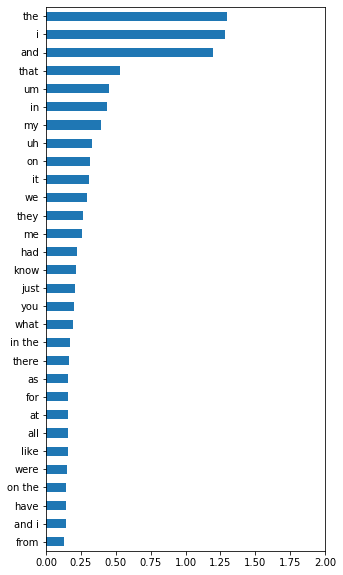

In [79]:
top_twenty_words_truthful = concat_df.groupby(by='target')[word_count_df.columns].agg(np.mean).T['truthful'].sort_values(ascending=False)
top_twenty_words_truthful.head(30).sort_values(ascending=True).plot(kind='barh',figsize=(5,10))
plt.xlim(0,2)

In [73]:
top_twenty_words_per_min = concat_df[word_count_df.columns].sum().sort_values(ascending=False).head(20).index
top_twenty_words_per_min

Index(['i', 'and', 'the', 'that', 'it', 'in', 'my', 'me', 'um', 'you', 'on',
       'just', 'had', 'we', 'they', 'uh', 'what', 'like', 'and i', 'as'],
      dtype='object')

In [74]:
I_plot = pd.DataFrame(concat_df.groupby(by='target')['i'].agg(np.mean)).T
I_plot

target,deceptive,truthful
i,1.326257,1.285288


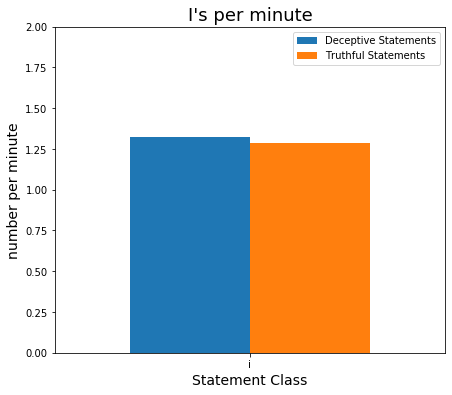

In [75]:
I_plot.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title("I's per minute", fontdict={'fontsize': 18})
plt.xlabel('Statement Class', fontdict={'fontsize': 14})

plt.ylabel('number per minute', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 2)
plt.show()

In [76]:
and_plot = pd.DataFrame(concat_df.groupby(by='target')['and'].agg(np.mean)).T
and_plot

target,deceptive,truthful
and,1.145,1.195769


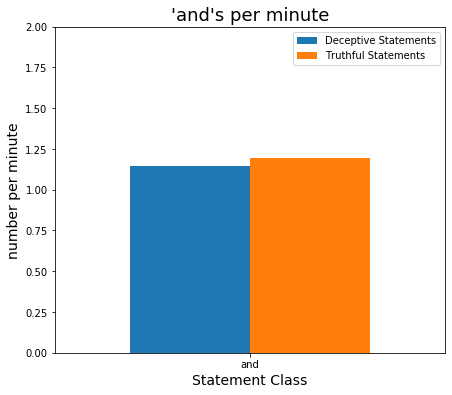

In [77]:
and_plot.plot(kind='bar', rot=0, figsize=(7,6), legend=False, width=0.8)
plt.title("'and's per minute", fontdict={'fontsize': 18})
plt.xlabel('Statement Class', fontdict={'fontsize': 14})

plt.ylabel('number per minute', fontdict={'fontsize': 14})
plt.legend(['Deceptive Statements','Truthful Statements'])
plt.ylim(0, 2)
plt.show()